In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import string
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

## Load in the data and set the helper variables

In [2]:
df = pd.read_excel (r'Data/Q_data_9.xlsx')
print(df.shape)

(9, 130)


In [3]:
maze_data = []
dirhome = os.path.dirname(os.path.realpath('__file__'))
directory = os.path.join(dirhome, 'Data\Maze Log')
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        print(filename)
        with open(os.path.join(directory, filename)) as json_file:
            data = json.load(json_file)
            maze_data.append(data)

05b85b0d-d3d9-4876-bc75-706b4e4d1cf3.VR_Maze.json
48f215f0-c6a4-4933-8d2c-f93ee8a31871.VR_Maze.json
7ad7b7bd-944d-446e-a376-66f6dca55aaf.VR_Maze.json
7f7b204e-1bf8-40fb-b299-99265bf9387c.VR_Maze.json
a5646206-e40b-43fc-ab35-8a1f6fde475b.VR_Maze.json
a8404373-e4dc-4fcb-8a67-4982d89635e8.VR_Maze.json
b3bb8a53-9379-4c8b-9bbe-c17997111ce9.VR_Maze.json
c5a26891-c64f-477b-ae5b-cb436685f07d.VR_Maze.json
fe5fde23-e6d4-44f5-a65d-8dffc032e526.VR_Maze.json


In [4]:
def col2num(col):
    num = 0
    for c in col:
        if c in string.ascii_letters:
            num = num * 26 + (ord(c.upper()) - ord('A')) + 1
    return num - 1

In [38]:
GENDER = col2num("K")
ID = col2num("J")
HAND = col2num("L")
HMD = col2num("P")
VR = col2num("M")
GAMES = col2num("N")
SSQs = [col2num("Q"),col2num("Z"),col2num("AK"),col2num("AV"),col2num("BG"),col2num("BR"),col2num("CC"),col2num("CN"),col2num("CY")]
ENDQNA = col2num("DJ")
SYMPTOMS = ["General Discomfort", "Fatigue", "Headache", "Eyestrain", "Difficulty Focusing", "Blurred Vision", "Dizziness", "Vertigo"]
oculSymptoms = ("General Discomfort", "Fatigue", "Eyestrain", "Difficulty Focusing")
disSymptoms = ("Headache", "Blurred Vision", "Dizziness", "Vertigo")
participantNum = df.shape[0]

In [6]:
print (df.iloc[:,ENDQNA])

0    2nd
1    2nd
2    1st
3    2nd
4    4th
5    4th
6    1st
7    1st
8    1st
Name: Teleportation, dtype: object


## Basic analyses of pre experiment questions

In [7]:
# Count males and females
males = 0
females = 0

for g in df.iloc[:,GENDER]:
    if g == "Male":
        males += 1
    else:
        females += 1

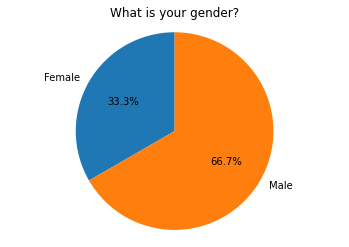

In [8]:
# Pie chart for gender
labels = ['Female', 'Male']
sizes = [females, males]
fig1, ax1 = plt.subplots()
ax1.set_title('What is your gender?')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [9]:
# Count Quest 1s and 2s
q1 = 0
q2 = 0

for g in df.iloc[:,HMD]:
    if g == "Quest 1":
        q1 += 1
    else:
        q2 += 1

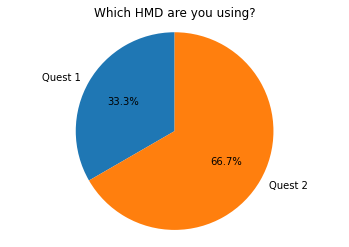

In [10]:
# Pie chart for gender
labels = ['Quest 1', 'Quest 2']
sizes = [q1, q2]

fig1, ax1 = plt.subplots()

ax1.set_title('Which HMD are you using?')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [11]:
# count how many times you have played vr before
VRcount = [0,0,0,0,0]
for g in df.iloc[:,VR]:
    if g == "Never":
        VRcount[0] += 1
    elif g == "1 - 3 times":
        VRcount[1] += 1
    elif g == "4 - 6 times":
        VRcount[2] += 1
    elif g == "7 - 9 times":
        VRcount[3] += 1
    elif g == "10 or more":
        VRcount[4] += 1

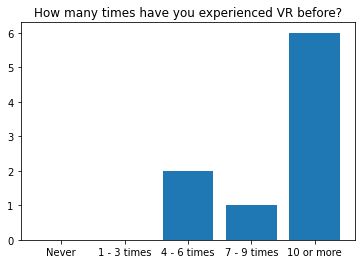

In [12]:
fig1, ax1 = plt.subplots()
ax1.set_title('How many times have you experienced VR before?')
time_frame = ['Never', '1 - 3 times', '4 - 6 times', '7 - 9 times', '10 or more']
ax1.bar(time_frame,VRcount)
plt.show()

In [13]:
# count how many times you have played game before
Gamecount = [0,0,0,0,0]
for g in df.iloc[:,GAMES]:
    if g == "Never":
        Gamecount[0] += 1
    elif g == "1 - 2 times":
        Gamecount[1] += 1
    elif g == "2 -5 times":
        Gamecount[2] += 1
    elif g == "5 - 7 times":
        Gamecount[3] += 1
    elif g == "7+ times":
        Gamecount[4] += 1

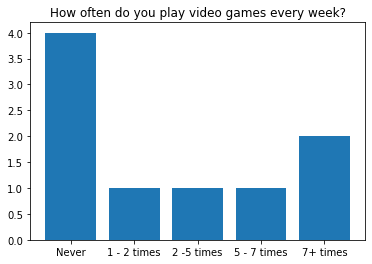

In [14]:
fig1, ax1 = plt.subplots()
ax1.set_title('How often do you play video games every week?')
time_frame = ['Never', '1 - 2 times', '2 -5 times', '5 - 7 times', '7+ times']
ax1.bar(time_frame,Gamecount)
plt.show()

## VRSQ analyses

In [15]:
def feelingToNumber(vals):
    ret = []
    for val in vals:
        if val == 'Not at all':
            ret.append(0)
        elif val == 'Slightly':
            ret.append(1)
        elif val == 'Moderately':
            ret.append(2)
        elif val == 'Very':
            ret.append(3)
        else:
            print('Wrong Value')
    return ret[0] if len(ret) == 1 else ret

In [16]:
def oculDisSplit(vals):
    """Input: df of one VRSSQ
    
    Return: Two lists with Oculomotor and Disorientation results"""
    ocul = []
    dis = []
    for i in range(len(SYMPTOMS)):
        if SYMPTOMS[i] in oculSymptoms:
            ocul.append(vals[i])
        elif SYMPTOMS[i] in disSymptoms:
            dis.append(vals[i])
    return ocul, dis

In [17]:
def calcOculScore(vals):
    score = 0
    for val in vals:
        score += feelingToNumber([val])
    score = (score/12)*100
    return score

In [18]:
def calcDisScore(vals):
    score = 0
    for val in vals:
        score += feelingToNumber([val])
    score = (score/15)*100
    return score

In [19]:
def calcTotalScore(o, d):
    return (o+d)/2

In [20]:
def calcVRSQ(result):
    ocul, dis = oculDisSplit(result)
    oculScore = calcOculScore(ocul)
    disScore = calcDisScore(dis)
    totalScore = calcTotalScore(oculScore, disScore)
    return oculScore, disScore, totalScore

In [21]:
test = df.iloc[1,SSQs[0]:SSQs[0]+9]
print(test)
o, d, t = calcVRSQ(test)
print("Oculomotor Score: {}\nDisorientation Score: {}\nTotal Score: {}".format(o, d, t))

General Discomfort           Slightly
Fatigue                    Moderately
Headache                   Not at all
Eyestrain                    Slightly
Difficulty Focusing          Slightly
Blurred Vision               Slightly
Dizziness (eyes closed)      Slightly
Vertigo                      Slightly
Fullness of Head             Slightly
Name: 1, dtype: object
Oculomotor Score: 41.66666666666667
Disorientation Score: 20.0
Total Score: 30.833333333333336


In [22]:
for p in range(participantNum):
    participant = df.iloc[p,SSQs[0]:SSQs[0]+9]
    participant_val = feelingToNumber(participant)
    o, d, t = calcVRSQ(participant)
    print("Participant {}:\nOculomotor Score: {}\nDisorientation Score: {}\nTotal Score: {}\n".format(p, o, d, t))

Participant 0:
Oculomotor Score: 16.666666666666664
Disorientation Score: 0.0
Total Score: 8.333333333333332

Participant 1:
Oculomotor Score: 41.66666666666667
Disorientation Score: 20.0
Total Score: 30.833333333333336

Participant 2:
Oculomotor Score: 25.0
Disorientation Score: 13.333333333333334
Total Score: 19.166666666666668

Participant 3:
Oculomotor Score: 16.666666666666664
Disorientation Score: 0.0
Total Score: 8.333333333333332

Participant 4:
Oculomotor Score: 16.666666666666664
Disorientation Score: 0.0
Total Score: 8.333333333333332

Participant 5:
Oculomotor Score: 25.0
Disorientation Score: 6.666666666666667
Total Score: 15.833333333333334

Participant 6:
Oculomotor Score: 0.0
Disorientation Score: 0.0
Total Score: 0.0

Participant 7:
Oculomotor Score: 0.0
Disorientation Score: 0.0
Total Score: 0.0

Participant 8:
Oculomotor Score: 0.0
Disorientation Score: 0.0
Total Score: 0.0



In [23]:
pre_experiment_vrsq_average = []
pre_experiment_vrsq_symptoms = np.zeros((participantNum, 9))
for p in range(participantNum):
    participant = df.iloc[p,SSQs[0]:SSQs[0]+9]
    participant_val = feelingToNumber(participant)
    pre_experiment_vrsq_symptoms[p,:] = participant_val
    o, d, t = calcVRSQ(participant)
    pre_experiment_vrsq_average.append([o,d,t])
pre_experiment_vrsq_average = np.array(pre_experiment_vrsq_average)
average_o = np.mean(pre_experiment_vrsq_average[:,0])
average_d = np.mean(pre_experiment_vrsq_average[:,1])
average_t = np.mean(pre_experiment_vrsq_average[:,2])
print("Average Oculomotor Score: {}\nAverage Disorientation Score: {}\nAverage Total Score: {}\n".format(average_o, average_d, average_t))

Average Oculomotor Score: 15.74074074074074
Average Disorientation Score: 4.444444444444445
Average Total Score: 10.092592592592593



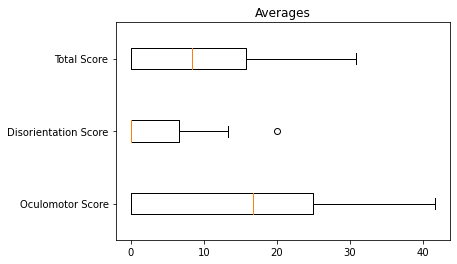

In [24]:
fig1, ax1 = plt.subplots()
ax1.set_title('Averages')
ax1.boxplot(pre_experiment_vrsq_average, vert=False)
plt.yticks([1, 2, 3], ['Oculomotor Score', 'Disorientation Score', 'Total Score'])
plt.show()

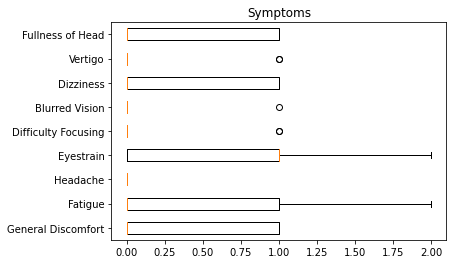

In [25]:
fig1, ax1 = plt.subplots()
ax1.set_title('Symptoms')
ax1.boxplot(pre_experiment_vrsq_symptoms, vert=False)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9], ['General Discomfort', 'Fatigue', 'Headache', 'Eyestrain', 'Difficulty Focusing', 'Blurred Vision', 'Dizziness', 'Vertigo', 'Fullness of Head'])
plt.show()

In [50]:

ids = df.iloc[:,ID]
vrsq_order = []
dict_template = {"Square":{"Teleport":0, "Dash":0,"Blur":0,"Fog":0},
                 "Circle":{"Teleport":0, "Dash":0,"Blur":0,"Fog":0}
                 }
for i in range(9):
    vrsq_order.append(dict_template)
for q, id in enumerate(ids):
    file_id = None
    for d in range(9):
        data = maze_data[d]
        for i in data['eventRecords']:
            if i['eventIdentifier'] == "ID":
                if i['eventDescription'] == str(id):
                    file_id = d
                    break
        if file_id is not None:
            break
    data = maze_data[file_id]
    ma = ""
    count = 1
    for i in data['eventRecords']:
        if i['eventIdentifier'] == "MA":
            if i['eventDescription'] == "Rotation Maze":
                    ma = "Square"
            elif i['eventDescription'] == "Back and Forth Maze":
                    ma = "Circle"
        if i['eventIdentifier'] == "MT":
            vrsq_order[q][ma][i['eventDescription']] = count
            count += 1



[{'Square': {'Teleport': 2, 'Dash': 1, 'Blur': 6, 'Fog': 5}, 'Circle': {'Teleport': 4, 'Dash': 7, 'Blur': 8, 'Fog': 3}}, {'Square': {'Teleport': 2, 'Dash': 1, 'Blur': 6, 'Fog': 5}, 'Circle': {'Teleport': 4, 'Dash': 7, 'Blur': 8, 'Fog': 3}}, {'Square': {'Teleport': 2, 'Dash': 1, 'Blur': 6, 'Fog': 5}, 'Circle': {'Teleport': 4, 'Dash': 7, 'Blur': 8, 'Fog': 3}}, {'Square': {'Teleport': 2, 'Dash': 1, 'Blur': 6, 'Fog': 5}, 'Circle': {'Teleport': 4, 'Dash': 7, 'Blur': 8, 'Fog': 3}}, {'Square': {'Teleport': 2, 'Dash': 1, 'Blur': 6, 'Fog': 5}, 'Circle': {'Teleport': 4, 'Dash': 7, 'Blur': 8, 'Fog': 3}}, {'Square': {'Teleport': 2, 'Dash': 1, 'Blur': 6, 'Fog': 5}, 'Circle': {'Teleport': 4, 'Dash': 7, 'Blur': 8, 'Fog': 3}}, {'Square': {'Teleport': 2, 'Dash': 1, 'Blur': 6, 'Fog': 5}, 'Circle': {'Teleport': 4, 'Dash': 7, 'Blur': 8, 'Fog': 3}}, {'Square': {'Teleport': 2, 'Dash': 1, 'Blur': 6, 'Fog': 5}, 'Circle': {'Teleport': 4, 'Dash': 7, 'Blur': 8, 'Fog': 3}}, {'Square': {'Teleport': 2, 'Dash': 1, '

In [72]:
## maze + locomotion combo
vrsq_lm = np.zeros((8,9,3))
mazes = ["Square", "Circle"]
locomotions = ["Teleport", "Dash", "Blur", "Fog"]
lm_count = 0
for m in mazes:
    for l in locomotions:
        for p in range(participantNum):
            order = vrsq_order[p][m][l]
            participant = df.iloc[p,SSQs[order]:SSQs[order]+9]
            participant_val = feelingToNumber(participant)
            pre_experiment_vrsq_symptoms[p,:] = participant_val
            o, d, t = calcVRSQ(participant)
            vrsq_lm[lm_count,p,0] = o
            vrsq_lm[lm_count,p,1] = d
            vrsq_lm[lm_count,p,2] = t
        lm_count += 1


## just locomotion
vrsq_l = np.zeros((4,18,3))
l_count = 0

for l in locomotions:
    m_count = 1
    for m in mazes:
        for p in range(participantNum):
            order = vrsq_order[p][m][l]
            participant = df.iloc[p,SSQs[order]:SSQs[order]+9]
            participant_val = feelingToNumber(participant)
            pre_experiment_vrsq_symptoms[p,:] = participant_val
            o, d, t = calcVRSQ(participant)
            vrsq_l[l_count,p*m_count,0] = o
            vrsq_l[l_count,p*m_count,1] = d
            vrsq_l[l_count,p*m_count,2] = t
        m_count += 1
    l_count += 1


## plot them on a graph

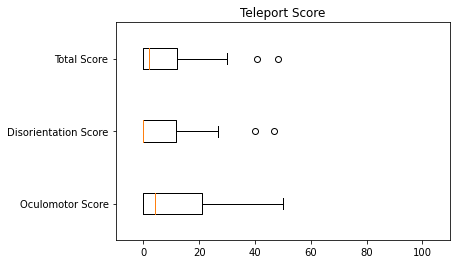

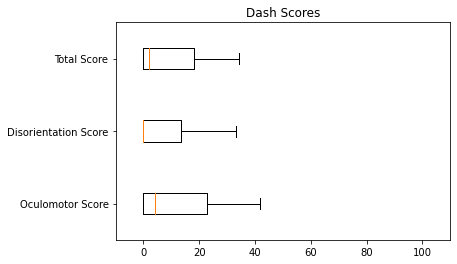

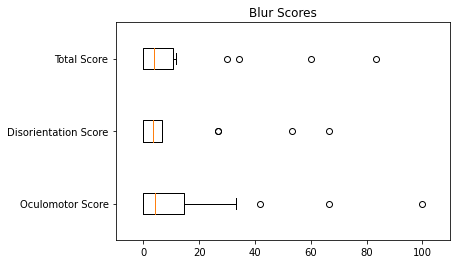

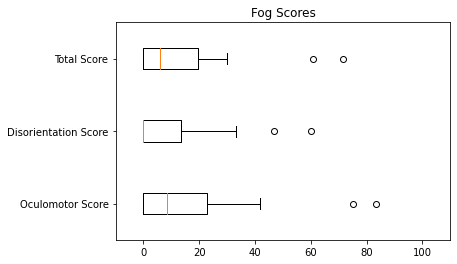

In [85]:
fig1, ax1 = plt.subplots()
ax1.set_title('Teleport Score')
ax1.boxplot(vrsq_l[0,:,:], vert=False)
plt.yticks([1, 2, 3], ['Oculomotor Score', 'Disorientation Score', 'Total Score'])
plt.xlim([-10, 110])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('Dash Scores')
ax1.boxplot(vrsq_l[1,:,:], vert=False)
plt.yticks([1, 2, 3], ['Oculomotor Score', 'Disorientation Score', 'Total Score'])
plt.xlim([-10, 110])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('Blur Scores')
ax1.boxplot(vrsq_l[2,:,:], vert=False)
plt.yticks([1, 2, 3], ['Oculomotor Score', 'Disorientation Score', 'Total Score'])
plt.xlim([-10, 110])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('Fog Scores')
ax1.boxplot(vrsq_l[3,:,:], vert=False)
plt.yticks([1, 2, 3], ['Oculomotor Score', 'Disorientation Score', 'Total Score'])
plt.xlim([-10, 110])
plt.show()

In [82]:
stat, p = friedmanchisquare(vrsq_l[0,:,2], vrsq_l[1,:,2], vrsq_l[2,:,2])
print("Statistic: {}".format(stat))
print("P value: {}".format(p))

Statistic: 0.9142857142856817
P value: 0.6330898921891916


## Maze log analyses

In [27]:
# Get the data from maze log

data = maze_data[0]
'''
ID - id
SR - Snap Rotation
MA - Maze type
MT - Movement type
PS - Angle

To find angle:
    first find the ps event
    Followed by MT to find the movement type

'''
# Find the angle locomotion method pair
def getAngleLocomotionPair(data):
    angleFound = False
    tempAngle = 0

    pairs = {}
    for i in data['eventRecords']:
        if i['eventIdentifier'] == "PS":
            angleFound = True
            tempAngle = i['eventDescription']
        if i['eventIdentifier'] == "MT" and angleFound:
            angleFound = False
            pairs[i['eventDescription']] = tempAngle
    return pairs


def sortAngles(pairs):
    angles = []
    angles.append(pairs['Teleport'])
    angles.append(pairs['Dash'])
    angles.append(pairs['Blur'])
    angles.append(pairs['Fog'])
    return angles

def getAnlges(datas):
    angles = np.zeros((9,4))

    for i, data in enumerate(datas):
        tempAngles = []
        pairs = getAngleLocomotionPair(data)
        tempAngles = sortAngles(pairs)
        angles[i,:] = tempAngles
    return angles


# Count the number of times each user used snap rotation
def userSanpRotation(data):
    count = 0
    for i in data['eventRecords']:
        if i['eventIdentifier'] == "SR":
            count +=1
    return count
# count the number of times each user used sanp rotation in different types of mazes
def mazeSnapRotation(data):
    squareMaze = 0
    circleMaze = 0
    tempCount = 0
    for i in data['eventRecords']:
        if i['eventIdentifier'] == "MA":
            if i['eventDescription'] == "Rotation Maze":
                circleMaze = tempCount
            elif i['eventDescription'] == "Back and Forth Maze":
                squareMaze = tempCount
            tempCount = 0
            tempAngle = i['eventDescription']
        if i['eventIdentifier'] == "SR":
            tempCount +=1
    return squareMaze, circleMaze

# count the number of times each user used snap rotation with each locomotion method
def locomotionSnapRotation(data):
    locomotionCount = [0,0,0,0]
    tempCount = 0
    for i in data['eventRecords']:
        if i['eventIdentifier'] == "MT":
            if i['eventDescription'] == "Teleport":
                locomotionCount[0] = tempCount
            elif i['eventDescription'] == "Dash":
                locomotionCount[1] = tempCount
            elif i['eventDescription'] == "Blur":
                locomotionCount[2] = tempCount
            elif i['eventDescription'] == "Fog":
                locomotionCount[3] = tempCount
            tempCount = 0
            tempAngle = i['eventDescription']
        if i['eventIdentifier'] == "SR":
            tempCount +=1
    return locomotionCount

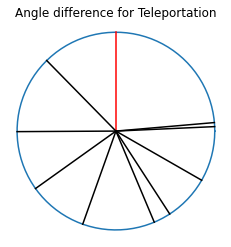

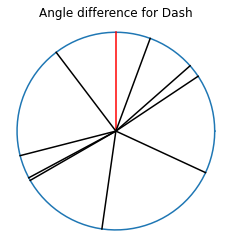

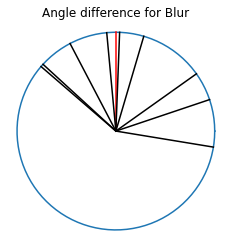

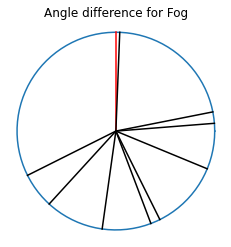

In [28]:
# TODO add the 45 angle offset
def calcCoordinates(angle):

    if angle < 0:
        angle = 360 + angle
    x = np.sin(angle)
    y = np.cos(angle)
    return x, y



angles = getAnlges(maze_data)
# Plot the circle
theta = np.linspace(0, 2*np.pi, 100)

radius = 1

a = radius*np.cos(theta)
b = radius*np.sin(theta)

figure, axes = plt.subplots(1)

axes.plot(a, b)
axes.plot([0,0],[0,1], color='red') # 0 degrees
for i in range(9):
    x,y = calcCoordinates(angles[i,0])
    axes.plot([0,x],[0,y], color='black')
axes.set_aspect(1)

plt.title('Angle difference for Teleportation')
plt.axis('off')
plt.show()

figure, axes = plt.subplots(1)

axes.plot(a, b)
axes.plot([0,0],[0,1], color='red') # 0 degrees
for i in range(9):
    x,y = calcCoordinates(angles[i,1])
    axes.plot([0,x],[0,y], color='black')
axes.set_aspect(1)

plt.title('Angle difference for Dash')
plt.axis('off')
plt.show()

figure, axes = plt.subplots(1)

axes.plot(a, b)
axes.plot([0,0],[0,1], color='red') # 0 degrees
for i in range(9):
    x,y = calcCoordinates(angles[i,2])
    axes.plot([0,x],[0,y], color='black')
axes.set_aspect(1)

plt.title('Angle difference for Blur')
plt.axis('off')
plt.show()

figure, axes = plt.subplots(1)

axes.plot(a, b)
axes.plot([0,0],[0,1], color='red') # 0 degrees
for i in range(9):
    x,y = calcCoordinates(angles[i,3])
    axes.plot([0,x],[0,y], color='black')
axes.set_aspect(1)

plt.title('Angle difference for Fog')
plt.axis('off')
plt.show()

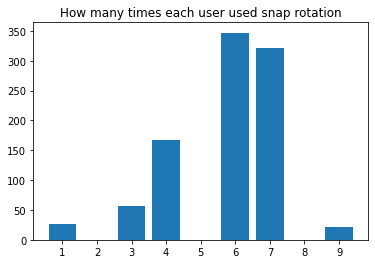

In [29]:
srcount = [0 for _ in range(9)]
for i in range(9):
    srcount[i] = userSanpRotation(maze_data[i])
fig1, ax1 = plt.subplots()
ax1.set_title('How many times each user used snap rotation')
time_frame = ['1', '2', '3', '4', '5','6','7','8','9']
ax1.bar(time_frame,srcount)
plt.show()

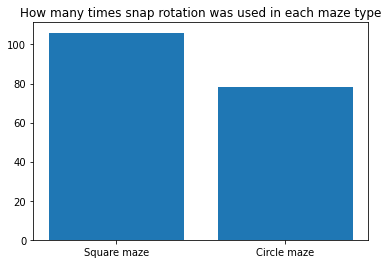

In [30]:
ss = 0
cs = 0
for i in range(9):
    s, c = mazeSnapRotation(maze_data[i])
    ss += s
    cs += c

fig1, ax1 = plt.subplots()
ax1.set_title('How many times snap rotation was used in each maze type')
time_frame = ['Square maze', 'Circle maze']
ax1.bar(time_frame,[ss,cs])
plt.show()

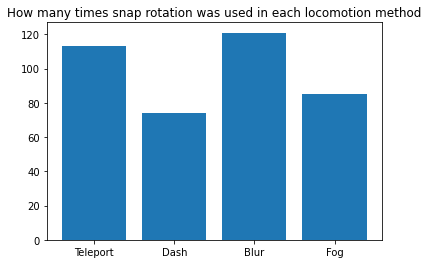

In [31]:
locomotionsr = [0,0,0,0]

for i in range(9):
    l = locomotionSnapRotation(maze_data[i])
    for j in range(4):
        locomotionsr[j] += l[j]

fig1, ax1 = plt.subplots()
ax1.set_title('How many times snap rotation was used in each locomotion method')
time_frame = ['Teleport', 'Dash','Blur','Fog']
ax1.bar(time_frame,locomotionsr)
plt.show()

## Post experiment questions analyses

In [32]:
temp = []
for i in range(4):
    test = df.iloc[:,ENDQNA+4*i:ENDQNA+4*i+4]
    temp.append(test)
temp = np.array(temp)
temp = temp.reshape(36,4)
for i in range(36):
    for j in range(4):
        if temp[i,j] == "1st":
            temp[i,j] = 1
        elif temp[i,j] == "2nd":
            temp[i,j] = 2
        elif temp[i,j] == "3rd":
            temp[i,j] = 3
        elif temp[i,j] == "4th":
            temp[i,j] = 4
stat, p = friedmanchisquare(temp[:,0], temp[:,1], temp[:,2], temp[:,3])
print("Statistic: {}".format(stat))
print("P value: {}".format(p))

Statistic: 12.34261838440106
P value: 0.006297076878939269


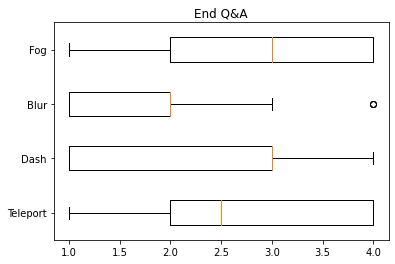

In [33]:
fig1, ax1 = plt.subplots()
ax1.set_title('End Q&A')
ax1.boxplot(temp, vert=False)
plt.yticks([1, 2, 3,4], ['Teleport', 'Dash', 'Blur', 'Fog'])
plt.show()

In [34]:
colum_names = {0: "Teleport", 1: "Dash",2:"Blur", 3:"Fog"}
r = sp.posthoc_nemenyi_friedman(np.array(temp, dtype='i'))
r.rename(index=colum_names ,columns=colum_names)

,Teleport,Dash,Blur,Fog
Teleport,1.000000,0.772753,0.202308,0.490308
Dash,0.772753,1.000000,0.695892,0.091664
Blur,0.202308,0.695892,1.000000,0.004076
Fog,0.490308,0.091664,0.004076,1.000000


In [35]:
r = sp.posthoc_conover_friedman(np.array(temp, dtype='i'))
r.rename(index=colum_names ,columns=colum_names)

,Teleport,Dash,Blur,Fog
Teleport,1.000000,0.364423,0.052826,0.160928
Dash,0.364423,1.000000,0.297247,0.022115
Blur,0.052826,0.297247,1.000000,0.001051
Fog,0.160928,0.022115,0.001051,1.000000


In [36]:
r = sp.posthoc_siegel_friedman(np.array(temp, dtype='i'))
r.rename(index=colum_names ,columns=colum_names)

,Teleport,Dash,Blur,Fog
Teleport,1.000000,0.361310,0.049684,0.157083
Dash,0.361310,1.000000,0.293809,0.019922
Blur,0.049684,0.293809,1.000000,0.000731
Fog,0.157083,0.019922,0.000731,1.000000


In [37]:
r = sp.posthoc_miller_friedman(np.array(temp, dtype='i'))
r.rename(index=colum_names ,columns=colum_names)

,Teleport,Dash,Blur,Fog
Teleport,1.000000,0.841479,0.277886,0.571974
Dash,0.841479,1.000000,0.776571,0.143580
Blur,0.277886,0.776571,1.000000,0.009711
Fog,0.571974,0.143580,0.009711,1.000000


In [ ]:
# TODO plot the maze maps
# TODO calculate the wrong moves in the mazes
# TODO Cross reference the resutls from mazes and responces to the questions